# Loading Data

## Imports

In [1]:
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Input, Flatten, LeakyReLU, ReLU, Conv2D, MaxPooling2D, UpSampling2D, Conv2DTranspose, concatenate, Activation
# from tensorflow.keras.utils import plot_model
# from tensorflow.keras.backend import clear_session
# from tensorflow.keras.optimizers import Adam, RMSprop , SGD
from tensorflow.keras import Sequential, Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
# from tensorflow.keras.regularizers import L2
# from tensorflow.keras import metrics
# import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import layers
from tensorflow import keras
import keras_tuner as kt
from keras import backend as K
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, UpSampling2D, concatenate
import tensorflow as tf

from os.path import join
from os import listdir
from shutil import copy

import numpy as np
import matplotlib.pyplot as plt
# import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import cv2

## Creating data loaders

In [2]:
IMAGE_SIZE = (64,64)

In [3]:
# import pandas as pd
# import numpy as np

# # Assuming you have already read the CSV into df
# df = pd.read_csv('.\\final_data_v2.csv', names=["path", "value"])

# # Select 20 random entries for the TEST set
# test_indices = np.random.choice(df.index, size=20, replace=False)
# test_df = df.loc[test_indices]

# # Create TRAIN set by excluding TEST entries
# train_df = df.drop(test_indices)

# # Save TEST set to a CSV file
# test_df.to_csv('test_data_v2.csv', index=False)

# # Optionally, save TRAIN set to a CSV file
# train_df.to_csv('train_data_v2.csv', index=False)


In [4]:
train = pd.read_csv('.\\train_data_v2.csv',  names=["path","value"])
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
        width_shift_range = 0.5,
        height_shift_range = 0.5, 
        zoom_range = [0.7,1.0],
        horizontal_flip = True,
        vertical_flip = True,
        shear_range = 0.5,
        rotation_range = 45,
    ).flow_from_dataframe(
    train, 
    x_col="path", 
    y_col="value", 
    class_mode='raw', 
    batch_size=198,
    target_size=IMAGE_SIZE,
    )

test = pd.read_csv('.\\test_data_v2.csv',  names=["path","value"])
val_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    ).flow_from_dataframe(
    test, 
    x_col="path", 
    y_col="value", 
    class_mode='raw', 
    batch_size=198,
    target_size=IMAGE_SIZE,
    )

Found 79 validated image filenames.
Found 20 validated image filenames.


c:\Users\nealb\AppData\Local\miniconda3\envs\pd\lib\site-packages\keras\preprocessing\image.py:1139: UserWarning: Found 1 invalid image filename(s) in x_col="path". These filename(s) will be ignored.
  warnings.warn(
c:\Users\nealb\AppData\Local\miniconda3\envs\pd\lib\site-packages\keras\preprocessing\image.py:1139: UserWarning: Found 1 invalid image filename(s) in x_col="path". These filename(s) will be ignored.
  warnings.warn(


In [5]:
df = pd.read_csv('.\\final_data_v2.csv',  names=["path","value"])
generator = tf.keras.preprocessing.image.ImageDataGenerator(
    )

data_generator = generator.flow_from_dataframe(
    df, 
    x_col="path", 
    y_col="value", 
    class_mode='raw', 
    batch_size=99,
    target_size=IMAGE_SIZE,
    )

Found 99 validated image filenames.


In [6]:
epochs = 128
REDUCE_LR = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                              patience=5, min_lr=1e-8)
ES = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, mode="min", restore_best_weights=True)

In [7]:
Xs_TRAIN = []
Ys_TRAIN = []
Xs_TEST = []
Ys_TEST = []
Xs = []
Ys = []
iterations = 4
for i in range(iterations):
    x,y = next(train_generator)
    Xs_TRAIN.extend([np.array(value).astype(int) for value in x])
    Ys_TRAIN.extend([np.array(value.replace("'","")[1:-1].split(', ')).astype(float) for value in y])

x,y = next(val_generator)
Xs_TEST.extend([np.array(value).astype(int) for value in x])
Ys_TEST.extend([np.array(value.replace("'","")[1:-1].split(', ')).astype(float) for value in y])
    
    
for i in range(iterations):
    x,y = next(data_generator)
    Xs.extend([np.array(value).astype(int) for value in x])
    Ys.extend([np.array(value.replace("'","")[1:-1].split(', ')).astype(float) for value in y])
    

In [8]:
# MAXPH = np.max(np.array(Ys)[:,1])
# MINPH = np.min(np.array(Ys)[:,1])

# MAXMOISTURE = np.max(np.array(Ys)[:,0])
# MINMOISTURE = np.min(np.array(Ys)[:,0])

In [9]:
# print(MAXPH)
# print(MINPH)
# print(MAXMOISTURE)
# print(MINMOISTURE)

In [10]:

def get_mask(image):
    image = image.astype(np.uint8)
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    binr = cv2.threshold(gray, 16, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]
    binr = np.invert(binr)
    kernel = np.ones((3, 3), np.uint8)
    mask = cv2.erode(binr, kernel, iterations=2)
    mask = (mask // 255).astype(np.uint8)
    return mask

def process_image(image):
    rgb_image = image.astype(np.uint8)
    mask = get_mask(rgb_image)
    gray = cv2.cvtColor(rgb_image, cv2.COLOR_RGB2GRAY)
    rgb_planes = cv2.split(rgb_image)
    result_planes = []
    for plane in rgb_planes:
        processed_image = cv2.medianBlur(plane, 3)
        processed_image = cv2.bitwise_and(processed_image, processed_image, mask=mask)
        result_planes.append(processed_image)
    result = cv2.merge(result_planes)
    return result

def process_label(image, label):
    mask = get_mask(np.array(image))
    mask = mask.astype(np.uint8)
    moisture = np.zeros_like(mask, dtype=np.float32)
    ph = np.zeros_like(mask, dtype=np.float32)
    moisture_value = label[0]
    ph_value = label[1]
    moisture[mask == 1] = moisture_value
    ph[mask == 1] = ph_value
    return moisture, ph

In [179]:
def mask_labels(mask, label):
    channel_0 = cv2.bitwise_and(label[0][0], label[0][0], mask=mask)
    channel_1 = cv2.bitwise_and(label[1][0], label[1][0], mask=mask)
    return [channel_0, channel_1]

def unprocess_label(label):
    label = np.array(label, dtype=float)
    label_0_flat = label[0].flatten()
    label_1_flat = label[1].flatten()
    filtered_label_0 = label_0_flat[label_0_flat != 0]
    filtered_label_1 = label_1_flat[label_1_flat != 0]
    moisture = filtered_label_0
    ph = filtered_label_1
    return [np.mean(moisture), np.mean(ph)]

def unprocess_label_wmask(image, label):
    
    def make_mask(image):
        image = np.array(image, dtype=np.uint8)
        gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
        mask = (gray > 0).astype(np.uint8)
        return mask

    unnormalized_image = np.array(image * 255).astype(np.uint8)
    mask = make_mask(unnormalized_image)
    soil_area = np.sum(mask)
    mean_moisture = np.sum(image[:, :, 0] * mask) / soil_area
    mean_acidity = np.sum(image[:, :, 1] * mask) / soil_area
    # Mask the labels
    # masked_labels = mask_labels(mask, label)
    # results = unprocess_label(masked_labels)
    return mean_moisture, mean_acidity

In [12]:
X_train = []
X_test = []
y_train = []
y_test = []
for i, x in enumerate(Xs_TRAIN):
    y_train.append(process_label(Xs_TRAIN[i], Ys_TRAIN[i]))
    X_train.append(process_image(Xs_TRAIN[i]))

for i, x in enumerate(Xs_TEST):
    y_test.append(process_label(Xs_TEST[i], Ys_TEST[i]))
    X_test.append(process_image(Xs_TEST[i]))

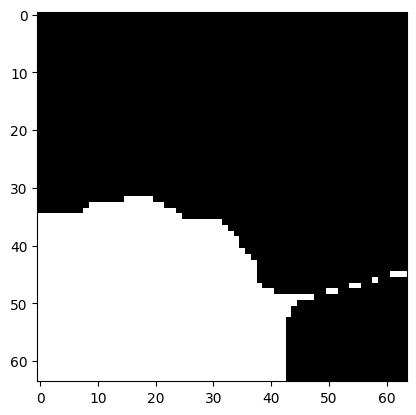

In [13]:
plt.imshow(np.array(y_train)[11][0], cmap="gray")

In [303]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.utils import Sequence

class MultiOutputDataGenerator(Sequence):
    def __init__(self, X, y, batch_size, rescale=None):
        self.X = X
        self.y = y
        self.batch_size = batch_size
        self.rescale = rescale
        self.indexes = np.arange(len(X))

    def __len__(self):
        return int(np.ceil(len(self.X) / float(self.batch_size)))

    def __getitem__(self, idx):
        batch_indexes = self.indexes[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_X = np.array([self.X[i] for i in batch_indexes])
        batch_y = [np.array([self.y[i][0] for i in batch_indexes]),  # Moisture
                   np.array([self.y[i][1] for i in batch_indexes])]  # pH

        if self.rescale:
            batch_X = batch_X * self.rescale

        return batch_X, {'moisture_output': batch_y[0], 'ph_output': batch_y[1]}

    def on_epoch_end(self):
        np.random.shuffle(self.indexes)


train_generator = MultiOutputDataGenerator(X_train, y_train, batch_size=4, rescale=1./255)
val_generator = MultiOutputDataGenerator(X_test, y_test, batch_size=4, rescale=1./255)

train_gen_iter = iter(train_generator)
val_gen_iter = iter(val_generator)

In [304]:
SAMPLE_TRAIN = []
SAMPLE_TRAIN_Y = []

## Prepare set of x values and y values
X_values_1,y_values_1 = [],[]
for i in range(316//4):
    values = next(train_gen_iter)
    X_values_1.append(values[0]) 
    y_values_1.append([values[1]['moisture_output'],values[1]['ph_output']])
    SAMPLE_TRAIN.extend(values[0])
    SAMPLE_TRAIN_Y.extend(list(zip(values[1]["moisture_output"], values[1]["ph_output"])))
    
SAMPLE_TRAIN_Y = np.array(SAMPLE_TRAIN_Y)

SAMPLE_TRAIN_Y = SAMPLE_TRAIN_Y[:, :, np.newaxis, :, :, np.newaxis]

## create X_values generator
gen_X_values_1_1 = (x for x in X_values_1)
gen_X_values_2_1 = (x for x in X_values_1)
gen_X_values_3_1 = (x for x in X_values_1)

## Prepare set of x values and y values
X_values_2,y_values_2 = [],[]
SAMPLE = []
SAMPLE_Y = []
for i in range(5):
    values = next(val_gen_iter)
    X_values_2.append(values[0])
    y_values_2.append(list(zip(values[1]["moisture_output"], values[1]["ph_output"])))
    SAMPLE.extend(values[0])
    SAMPLE_Y.extend(list(zip(values[1]["moisture_output"], values[1]["ph_output"])))

## create X_values generator
gen_X_values_1_2 = (x for x in X_values_2)
gen_X_values_2_2 = (x for x in X_values_2)
gen_X_values_3_2 = (x for x in X_values_2)

SAMPLE_Y = np.array(SAMPLE_Y)

SAMPLE_Y = SAMPLE_Y[:, :, np.newaxis, :, :, np.newaxis]

    

In [163]:
np.array(y_values_1)[:, 0].shape

(79, 4, 64, 64)

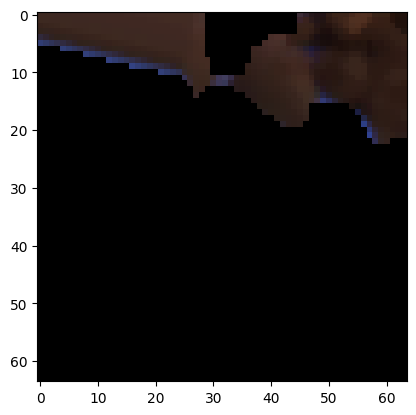

In [16]:
plt.imshow(np.array(X_train)[0])

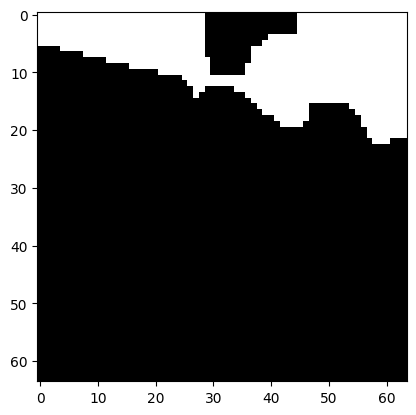

In [17]:
plt.imshow(np.array(y_train)[0][1],cmap='gray')

In [18]:
np.array(y_train)[0][0]

array([[0.14, 0.14, 0.14, ..., 0.14, 0.14, 0.14],
       [0.14, 0.14, 0.14, ..., 0.14, 0.14, 0.14],
       [0.14, 0.14, 0.14, ..., 0.14, 0.14, 0.14],
       ...,
       [0.  , 0.  , 0.  , ..., 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , ..., 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , ..., 0.  , 0.  , 0.  ]], dtype=float32)

In [19]:
x_col = "path"
y_col = "pH"
batch_size = 16
epochs = 1024
lr = 1e-5
image_size = (IMAGE_SIZE[0],IMAGE_SIZE[1])
channels = 3
shuffle = True
class_mode ="raw"
color_mode = "rgb"

# Evaluation of Designs

In [20]:
import tensorflow as tf
from tensorflow.keras import backend as K

def mean_squared_error(y_true, y_pred):
    y_pred = tf.convert_to_tensor(y_pred)
    y_true = tf.cast(y_true, y_pred.dtype)
    return K.mean(tf.math.squared_difference(y_pred, y_true), axis=[1,2])

def mean_absolute_error(y_true, y_pred):
    y_pred = tf.convert_to_tensor(y_pred)
    y_true = tf.cast(y_true, y_pred.dtype)
    return K.mean(tf.abs(y_pred - y_true), axis=[1,2])


In [22]:

import tensorflow as tf
from tensorflow.keras import backend as K

def root_mean_squared_error(y_true, y_pred):
    y_pred = tf.convert_to_tensor(y_pred)
    y_true = tf.cast(y_true, y_pred.dtype)
    return K.sqrt(K.mean(tf.square(y_pred - y_true), axis=[1,2]))

def mean_absolute_error(y_true, y_pred):
    y_pred = tf.convert_to_tensor(y_pred)
    y_true = tf.cast(y_true, y_pred.dtype)
    return K.mean(tf.abs(y_pred - y_true), axis=[1,2])


## Optimization of Designs

### Design A

In [106]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, BatchNormalization, Activation, Dropout, Concatenate, Flatten, Dense, Reshape
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.initializers import HeNormal

def convolution_block(inputs, num_filters, kernel_size=3, padding="same", use_bias=False):
    x = Conv2D(num_filters, kernel_size=kernel_size, padding=padding, use_bias=use_bias, kernel_initializer=HeNormal())(inputs)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    return x

def upsample_block(inputs, skip_features, num_filters):
    x = UpSampling2D((2, 2))(inputs)
    x = Conv2D(num_filters, (2, 2), padding="same")(x)
    x = Concatenate()([x, skip_features])
    x = convolution_block(x, num_filters)
    return x

def dense_upsampling_block(inputs, skip_features, num_filters):
    x = UpSampling2D((2, 2))(inputs)
    x = Conv2D(num_filters, (2, 2), padding="same")(x)
    x = Concatenate()([x, skip_features])
    x = convolution_block(x, num_filters)
    return x

def unet_plus_plus_model(hp, input_shape=(64, 64, 3)):
    inputs = Input(input_shape)

    resnet50 = ResNet50(include_top=False, weights='imagenet', input_tensor=inputs)
    resnet50.trainable = True

    # Encoder
    s1 = resnet50.get_layer("conv1_relu").output
    s2 = resnet50.get_layer("conv2_block3_out").output
    s3 = resnet50.get_layer("conv3_block4_out").output
    s4 = resnet50.get_layer("conv4_block6_out").output

    b1 = resnet50.get_layer("conv5_block3_out").output
    # Flatten the bottleneck output
    x = Flatten()(b1)
    UNITS = hp.Choice('units', values=[256, 512, 1024, 2048], default=256)
    DROPOUT = hp.Float('dropout', min_value=0.0, max_value=0.5, step=0.1, default=0.0)

    BATCHNORM = hp.Boolean('batchnorm', default=False)
    # Dense layers between encoder and decoder
    x = Dense(UNITS, activation='relu')(x)
    x = Dropout(DROPOUT)(x)
    x = Dense(UNITS, activation='relu')(x)
    x = Dropout(DROPOUT)(x)
    x = Dense(UNITS, activation='relu')(x)
    x = Dropout(DROPOUT)(x)
    x = Dense(UNITS, activation='relu')(x)
    # Reshape back to spatial dimensions for the decoder
    SIZE = input_shape[0] // 32  # Assuming input size is a multiple of 32
    if BATCHNORM:
        x = BatchNormalization()(x)
    x = Dense(SIZE * SIZE * 2048, activation='relu')(x)
    x = Reshape((SIZE, SIZE, 2048))(x)

    # Nested U-Net
    d4_2 = dense_upsampling_block(x, s4, 512)
    d3_2 = dense_upsampling_block(d4_2, s3, 256)
    d2_2 = dense_upsampling_block(d3_2, s2, 128)
    d1_2 = dense_upsampling_block(d2_2, s1, 64)

    d4_1 = upsample_block(x, s4, 512)
    d3_1 = upsample_block(d4_1, s3, 256)
    d2_1 = upsample_block(d3_1, s2, 128)
    d1_1 = upsample_block(d2_1, s1, 64)

    outputs = UpSampling2D()(d1_1)
    outputs1 = Conv2D(1, (1, 1), padding="same", activation="linear", name="moisture_output")(outputs)
    outputs2 = Conv2D(1, (1, 1), padding="same", activation="linear", name="ph_output")(outputs)
    model = tf.keras.Model(inputs=inputs, outputs=[outputs1, outputs2], name='Unet_plus_plus')

    optimizer_choice = hp.Choice('optimizer', values=['sgd', 'rmsprop', 'adam'], default='adam')
    lr = hp.Choice('learning_rate', values=[1e-3, 1e-4, 1e-5], default=1e-3)

    if optimizer_choice == 'sgd':
        optimizer = tf.keras.optimizers.SGD(learning_rate=lr)
    elif optimizer_choice == 'rmsprop':
        optimizer = tf.keras.optimizers.RMSprop(learning_rate=lr)
    else:
        optimizer = tf.keras.optimizers.Adam(learning_rate=lr)

    model.compile(optimizer=optimizer, 
                    loss={"moisture_output":root_mean_squared_error, "ph_output":root_mean_squared_error}, 
                    metrics={"moisture_output":mean_absolute_error,"ph_output":mean_absolute_error},
                    loss_weights={'moisture_output': 1.0, 'ph_output': 0.3}
                    )
    return model

In [107]:
tunerA = kt.BayesianOptimization(unet_plus_plus_model,
                     objective='val_loss',
                     directory='my_dir_v2-06-12-2024',
                     max_trials= 30,
                     project_name='design_a',
                    #  seed=42,
                     )

stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=6)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, min_lr=1e-8)

tunerA.search(train_generator, epochs=50, validation_data=val_generator, callbacks=[stop_early, reduce_lr])

# Get the optimal hyperparameters
best_hpsA=tunerA.get_best_hyperparameters(num_trials=1)[0]


print(best_hpsA.values)

Reloading Tuner from my_dir_v2-06-12-2024\design_a\tuner0.json
{'units': 2048, 'dropout': 0.30000000000000004, 'batchnorm': True, 'optimizer': 'adam', 'learning_rate': 0.001}


In [108]:
modelA = unet_plus_plus_model(best_hpsA)
modelA.summary()

Model: "Unet_plus_plus"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_11 (InputLayer)          [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 70, 70, 3)    0           ['input_11[0][0]']               
                                                                                                  
 conv1_conv (Conv2D)            (None, 32, 32, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 32, 32, 64)   256         ['conv1_conv[0][0]']             
                                                                                     

In [109]:
## DESIGN A
import time 
start = time.time()
historyA = modelA.fit(train_generator, epochs=epochs, validation_data=val_generator, verbose=1, callbacks = [ES, REDUCE_LR])
stop = time.time()
print(f"Training time: {stop - start}s")

Epoch 1/1024
79/79 [==============================] - 13s 86ms/step - loss: 0.3653 - moisture_output_loss: 0.1040 - ph_output_loss: 0.8712 - moisture_output_mean_absolute_error: 0.1771 - ph_output_mean_absolute_error: 0.6220 - val_loss: 5.2755 - val_moisture_output_loss: 0.7504 - val_ph_output_loss: 15.0839 - val_moisture_output_mean_absolute_error: 0.8235 - val_ph_output_mean_absolute_error: 3.0675 - lr: 0.0010
Epoch 2/1024
79/79 [==============================] - 6s 69ms/step - loss: 0.1112 - moisture_output_loss: 0.0092 - ph_output_loss: 0.3400 - moisture_output_mean_absolute_error: 0.0697 - ph_output_mean_absolute_error: 0.3502 - val_loss: 984.4977 - val_moisture_output_loss: 326.0729 - val_ph_output_loss: 2194.7490 - val_moisture_output_mean_absolute_error: 12.0947 - val_ph_output_mean_absolute_error: 34.3426 - lr: 0.0010
Epoch 3/1024
79/79 [==============================] - 6s 73ms/step - loss: 0.0981 - moisture_output_loss: 0.0076 - ph_output_loss: 0.3016 - moisture_output_mean_

1/1 [==============================] - 0s 23ms/step
Moisture Truth : 0.16 Pred: 0.16
ph   Truth: 0.09 Pred: 0.09

Moisture Truth : 0.20 Pred: 0.20
ph   Truth: 0.12 Pred: 0.12

Moisture Truth : 0.18 Pred: 0.18
ph   Truth: 0.11 Pred: 0.11

Moisture Truth : 0.17 Pred: 0.17
ph   Truth: 0.10 Pred: 0.10

Moisture Truth : 0.17 Pred: 0.17
ph   Truth: 0.10 Pred: 0.10

Moisture Truth : 0.18 Pred: 0.18
ph   Truth: 0.11 Pred: 0.11

Moisture Truth : 0.14 Pred: 0.14
ph   Truth: 0.09 Pred: 0.09

Moisture Truth : 0.18 Pred: 0.18
ph   Truth: 0.10 Pred: 0.10

Moisture Truth : 0.17 Pred: 0.17
ph   Truth: 0.10 Pred: 0.10

Moisture Truth : 0.14 Pred: 0.14
ph   Truth: 0.09 Pred: 0.09

Moisture Truth : 0.18 Pred: 0.18
ph   Truth: 0.11 Pred: 0.11

Moisture Truth : 0.14 Pred: 0.14
ph   Truth: 0.09 Pred: 0.09

Moisture Truth : 0.16 Pred: 0.16
ph   Truth: 0.10 Pred: 0.10

Moisture Truth : 0.19 Pred: 0.19
ph   Truth: 0.10 Pred: 0.10

Moisture Truth : 0.16 Pred: 0.16
ph   Truth: 0.09 Pred: 0.09

Moisture Truth : 0

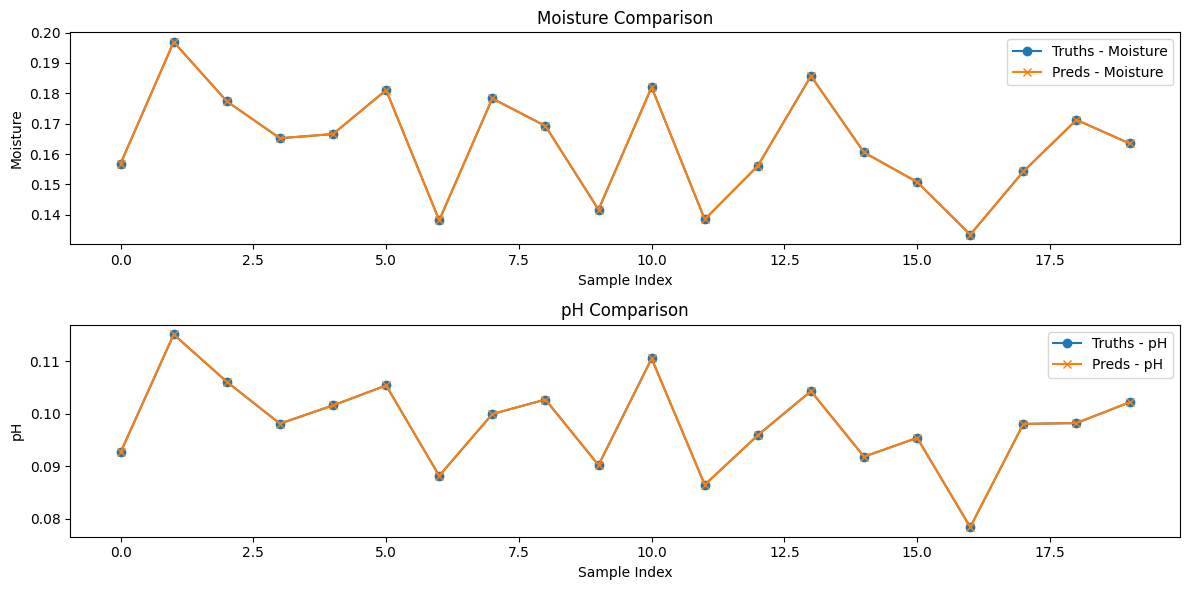

In [182]:

truths = []
preds = []
for i in range(20):
    predictions = modelA.predict(np.array([SAMPLE[i]]))
    truths.append(unprocess_label_wmask(SAMPLE[i],SAMPLE_Y[i]))
    preds.append(unprocess_label_wmask(SAMPLE[i],predictions))
truths_moisture = [truth[0] for truth in truths]
truths_ph = [truth[1] for truth in truths]
preds_moisture = [pred[0] for pred in preds]
preds_ph = [pred[1] for pred in preds]


for i in range(len(truths_moisture)):
    print("Moisture Truth : {:.2f} Pred: {:.2f}".format(truths_moisture[i], preds_moisture[i]))
    print("ph   Truth: {:.2f} Pred: {:.2f}".format(truths_ph[i], preds_ph[i]), end="\n\n")
plt.figure(figsize=(12, 6))

# Moisture Plot
plt.subplot(2, 1, 1)
plt.plot(truths_moisture, label='Truths - Moisture', marker='o')
plt.plot(preds_moisture, label='Preds - Moisture', marker='x')
plt.title('Moisture Comparison')
plt.xlabel('Sample Index')
plt.ylabel('Moisture')
plt.legend()

# pH Plot
plt.subplot(2, 1, 2)
plt.plot(truths_ph, label='Truths - pH', marker='o')
plt.plot(preds_ph, label='Preds - pH', marker='x')
plt.title('pH Comparison')
plt.xlabel('Sample Index')
plt.ylabel('pH')
plt.legend()

plt.tight_layout()
plt.show()




In [183]:
def accuracy(truth, pred):
    return (1 - abs(truth - pred) / truth) * 100

TEMP_0 = []
TEMP_1 = []
for i in range(len(truths_moisture)):
    TEMP_0.append(accuracy(truths_moisture[i],preds_moisture[i]))
    # print(accuracy(truths_moisture[i],preds_moisture[i]),accuracy(truths_ph[i],preds_ph[i]))
    TEMP_1.append(accuracy(truths_ph[i],preds_ph[i]))
print(np.mean(np.array(TEMP_0)))
print(np.mean(np.array(TEMP_1)))

100.0
100.0


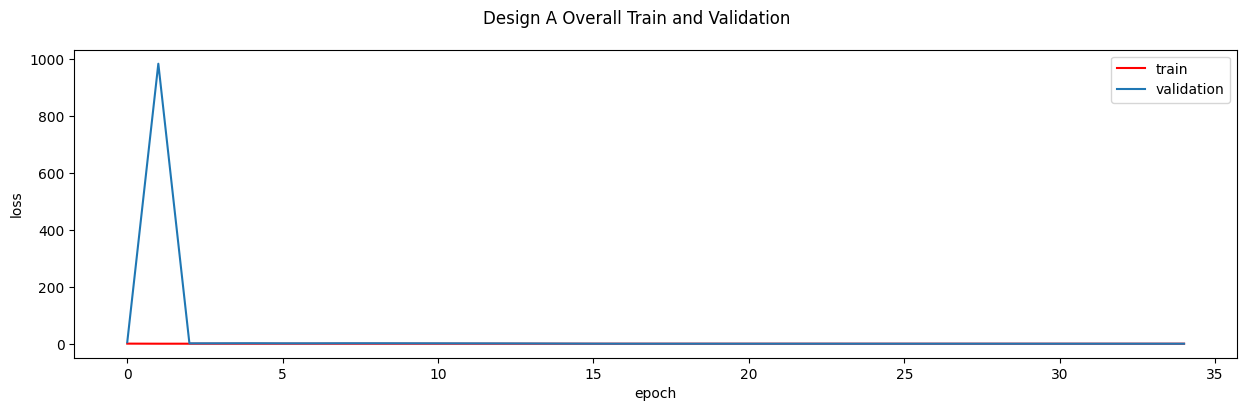

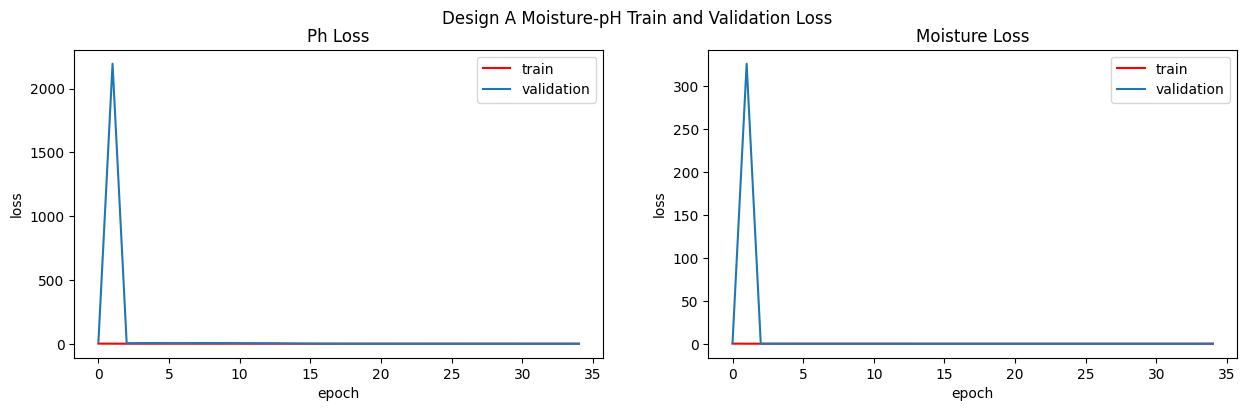

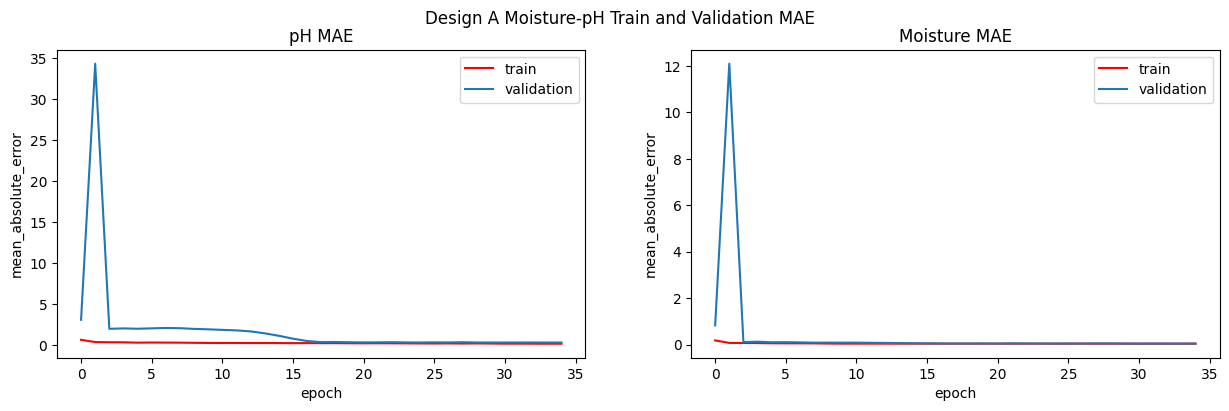

In [117]:
## Graphing Result of training
HISTORY = historyA


plt.figure(figsize=(15,4))
plt.suptitle("Design A Overall Train and Validation")

plt.subplot(111)
plt.plot(HISTORY.history['loss'], color ='r')
plt.plot(HISTORY.history['val_loss'])
plt.legend(['train','validation'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()


plt.figure(figsize=(15,4))
plt.suptitle("Design A Moisture-pH Train and Validation Loss")

plt.subplot(121)
plt.plot(HISTORY.history['ph_output_loss'], color ='r')
plt.plot(HISTORY.history['val_ph_output_loss'])
plt.title('Ph Loss')
plt.legend(['train','validation'])
plt.xlabel('epoch')
plt.ylabel('loss')

plt.subplot(122)
plt.plot(HISTORY.history['moisture_output_loss'], color ='r')
plt.plot(HISTORY.history['val_moisture_output_loss'])
plt.title('Moisture Loss')
plt.legend(['train','validation'])
plt.xlabel('epoch')
plt.ylabel('loss')

# displaying the figure
plt.show()

plt.figure(figsize=(15,4))
plt.suptitle("Design A Moisture-pH Train and Validation MAE")

plt.subplot(121)
plt.plot(HISTORY.history['ph_output_mean_absolute_error'], color ='r')
plt.plot(HISTORY.history['val_ph_output_mean_absolute_error'])
plt.title('pH MAE')
plt.legend(['train','validation'])
plt.xlabel('epoch')
plt.ylabel('mean_absolute_error')

plt.subplot(122)
plt.plot(HISTORY.history['moisture_output_mean_absolute_error'], color ='r')
plt.plot(HISTORY.history['val_moisture_output_mean_absolute_error'])
plt.title('Moisture MAE')
plt.legend(['train','validation'])
plt.xlabel('epoch')
plt.ylabel('mean_absolute_error')

# displaying the figure
plt.show()

In [118]:
## Design A
history = historyA.history

loss_keys = [key for key in history.keys() if 'loss' in key]
metric_keys = [key for key in history.keys() if 'mean_absolute_error' in key]

val_loss = history['val_loss']
best_epoch = np.argmin(val_loss)

print("Best Epoch: ", best_epoch)

for key in loss_keys + metric_keys:
    if key.startswith('val_'):
        metric_name = key[4:] 
        final_value = history[key][best_epoch]
        print(f"Final Validation {metric_name}: {final_value:.4f}")
    else:
        final_value = history[key][best_epoch]
        print(f"Final Train {key}: {final_value:.4f}")


Best Epoch:  24
Final Train loss: 0.0545
Final Train moisture_output_loss: 0.0029
Final Train ph_output_loss: 0.1719
Final Validation loss: 0.0984
Final Validation moisture_output_loss: 0.0035
Final Validation ph_output_loss: 0.3166
Final Train moisture_output_mean_absolute_error: 0.0361
Final Train ph_output_mean_absolute_error: 0.1802
Final Validation moisture_output_mean_absolute_error: 0.0423
Final Validation ph_output_mean_absolute_error: 0.2955


In [119]:
# from shutil import rmtree
# # removing directory 
# rmtree('my_dir') 

In [32]:
# modelA.save('design_models/designA_v6.h5')


### Design B

In [143]:


# import tensorflow as tf
# from tensorflow.keras import layers, Model
# from tensorflow.keras.applications import VGG16

def segnet(hp, input_shape=(64, 64, 3), num_classes=2):
    # Load the VGG16 model with batch normalization
    vgg16_bn = VGG16(include_top=False, weights='imagenet', input_shape=input_shape)
    vgg16_bn.trainable = True
    
    ## DITO KO LALAGAY
    
    # Encoder
    inputs = layers.Input(shape=input_shape)

    # Using the pretrained VGG16_bn layers
    x = vgg16_bn.get_layer('block1_conv1')(inputs)
    x = vgg16_bn.get_layer('block1_conv2')(x)
    stage1 = x
    x = vgg16_bn.get_layer('block1_pool')(x)

    x = vgg16_bn.get_layer('block2_conv1')(x)
    x = vgg16_bn.get_layer('block2_conv2')(x)
    stage2 = x
    x = vgg16_bn.get_layer('block2_pool')(x)

    x = vgg16_bn.get_layer('block3_conv1')(x)
    x = vgg16_bn.get_layer('block3_conv2')(x)
    x = vgg16_bn.get_layer('block3_conv3')(x)
    stage3 = x
    x = vgg16_bn.get_layer('block3_pool')(x)

    x = vgg16_bn.get_layer('block4_conv1')(x)
    x = vgg16_bn.get_layer('block4_conv2')(x)
    x = vgg16_bn.get_layer('block4_conv3')(x)
    stage4 = x
    x = vgg16_bn.get_layer('block4_pool')(x)

    x = vgg16_bn.get_layer('block5_conv1')(x)
    x = vgg16_bn.get_layer('block5_conv2')(x)
    x = vgg16_bn.get_layer('block5_conv3')(x)
    stage5 = x
    x = vgg16_bn.get_layer('block5_pool')(x)

    UNITS = hp.Choice('units',values = [256,512,1024,2048], default=256)
    DROPOUT = hp.Float('dropout',min_value=0.0, max_value=0.5, step=0.1, default=0.0)
    BATCHNORM = hp.Boolean('batchnorm',default=False)
    
    # Dense layers between encoder and decoder
    x = layers.Flatten()(x)
    x = Dense(UNITS, activation='relu')(x)
    x = Dropout(DROPOUT)(x)
    x = Dense(UNITS, activation='relu')(x)
    x = Dropout(DROPOUT)(x)
    x = Dense(UNITS, activation='relu')(x)
    x = Dropout(DROPOUT)(x)
    x = Dense(UNITS, activation='relu')(x)
    if BATCHNORM:
        x = BatchNormalization()(x)
    SIZE = input_shape[0]//32
    x = layers.Dense(SIZE*SIZE*512, activation='relu')(x)  # Adjust to match the new dimensions
    x = layers.Reshape((SIZE, SIZE, 512))(x)  # Adjust to match the new dimensions

    # Decoder
    x = layers.Conv2DTranspose(512, (3, 3), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.Conv2DTranspose(512, (3, 3), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.Conv2DTranspose(512, (3, 3), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.UpSampling2D()(x)

    # Incorporate stage5
    x = layers.Concatenate()([x, stage5])
    x = layers.Conv2DTranspose(512, (3, 3), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.Conv2DTranspose(512, (3, 3), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.Conv2DTranspose(256, (3, 3), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.UpSampling2D()(x)

    # Incorporate stage4
    x = layers.Concatenate()([x, stage4])
    x = layers.Conv2DTranspose(256, (3, 3), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.Conv2DTranspose(256, (3, 3), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.Conv2DTranspose(128, (3, 3), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.UpSampling2D()(x)

    # Incorporate stage3
    x = layers.Concatenate()([x, stage3])
    x = layers.Conv2DTranspose(128, (3, 3), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.Conv2DTranspose(64, (3, 3), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.UpSampling2D()(x)

    # Incorporate stage2
    x = layers.Concatenate()([x, stage2])
    x = layers.Conv2DTranspose(64, (3, 3), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.UpSampling2D()(x)

    # Incorporate stage1
    x = layers.Concatenate()([x, stage1])
    x = layers.Conv2DTranspose(64, (3, 3), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.Conv2DTranspose(num_classes, (3, 3), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    
    x = layers.Dropout(0.5)(x)
    
    outputs1 = Conv2D(1, (3, 3), padding="same", activation="linear", name="moisture_output")(x)
    outputs2 = Conv2D(1, (3, 3), padding="same", activation="linear", name="ph_output")(x)
    model = tf.keras.Model(inputs=inputs, outputs=[outputs1, outputs2], name='SegNet')

    optimizer_choice = hp.Choice('optimizer', values=['sgd', 'rmsprop', 'adam'], default='adam')
    lr = hp.Choice('learning_rate', values=[1e-3, 1e-4, 1e-5], default=1e-3)

    if optimizer_choice == 'sgd':
        optimizer = tf.keras.optimizers.SGD(learning_rate=lr)
    elif optimizer_choice == 'rmsprop':
        optimizer = tf.keras.optimizers.RMSprop(learning_rate=lr)
    else:
        optimizer = tf.keras.optimizers.Adam(learning_rate=lr)

    model.compile(optimizer=optimizer, 
                    loss={"moisture_output":root_mean_squared_error, "ph_output":root_mean_squared_error}, 
                    metrics={"moisture_output":mean_absolute_error,"ph_output":mean_absolute_error},
                    loss_weights={'moisture_output': 1.0, 'ph_output': 0.7}
                    )
    return model



In [144]:
tunerB = kt.BayesianOptimization(segnet,
                     objective='val_loss',
                     directory='my_dir_v2-06-12-2024',
                     max_trials= 30,
                     project_name='design_b',
                    #  seed=42,
                     )

stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=7)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, min_lr=1e-8)


tunerB.search(train_generator, epochs=30, validation_data=val_generator, callbacks=[stop_early, reduce_lr])

# Get the optimal hyperparameters
best_hpsB=tunerB.get_best_hyperparameters(num_trials=1)[0]



print(best_hpsB.values)

Reloading Tuner from my_dir_v2-06-12-2024\design_b\tuner0.json
{'units': 1024, 'dropout': 0.2, 'batchnorm': False, 'optimizer': 'rmsprop', 'learning_rate': 0.0001}


In [145]:
# Build the model with the best hp.
modelB = segnet(best_hpsB)
modelB.summary()

Model: "SegNet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_19 (InputLayer)          [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 block1_conv1 (Conv2D)          (None, 64, 64, 64)   1792        ['input_19[0][0]']               
                                                                                                  
 block1_conv2 (Conv2D)          (None, 64, 64, 64)   36928       ['block1_conv1[1][0]']           
                                                                                                  
 block1_pool (MaxPooling2D)     (None, 32, 32, 64)   0           ['block1_conv2[1][0]']           
                                                                                             

In [146]:
## DESIGN B
import time 
start = time.time()
historyB = modelB.fit(train_generator, epochs=epochs, validation_data=val_generator, verbose=2, callbacks = [ES, REDUCE_LR])
stop = time.time()
print(f"Training time: {stop - start}s")

Epoch 1/1024
79/79 - 11s - loss: 2.1638 - moisture_output_loss: 0.5323 - ph_output_loss: 2.3308 - moisture_output_mean_absolute_error: 0.4048 - ph_output_mean_absolute_error: 1.6386 - val_loss: 3.3068 - val_moisture_output_loss: 1.5838 - val_ph_output_loss: 2.4613 - val_moisture_output_mean_absolute_error: 1.4519 - val_ph_output_mean_absolute_error: 1.9546 - lr: 1.0000e-04 - 11s/epoch - 140ms/step
Epoch 2/1024
79/79 - 6s - loss: 1.9760 - moisture_output_loss: 0.3462 - ph_output_loss: 2.3282 - moisture_output_mean_absolute_error: 0.2638 - ph_output_mean_absolute_error: 1.6015 - val_loss: 2.6374 - val_moisture_output_loss: 0.7314 - val_ph_output_loss: 2.7229 - val_moisture_output_mean_absolute_error: 0.6739 - val_ph_output_mean_absolute_error: 2.0954 - lr: 1.0000e-04 - 6s/epoch - 76ms/step
Epoch 3/1024
79/79 - 6s - loss: 1.9176 - moisture_output_loss: 0.2760 - ph_output_loss: 2.3451 - moisture_output_mean_absolute_error: 0.2069 - ph_output_mean_absolute_error: 1.6022 - val_loss: 2.2834 -

1/1 [==============================] - 0s 19ms/step
Moisture Truth : 0.16 Pred: 0.16
ph   Truth: 0.09 Pred: 0.09

Moisture Truth : 0.20 Pred: 0.20
ph   Truth: 0.12 Pred: 0.12

Moisture Truth : 0.18 Pred: 0.18
ph   Truth: 0.11 Pred: 0.11

Moisture Truth : 0.17 Pred: 0.17
ph   Truth: 0.10 Pred: 0.10

Moisture Truth : 0.17 Pred: 0.17
ph   Truth: 0.10 Pred: 0.10

Moisture Truth : 0.18 Pred: 0.18
ph   Truth: 0.11 Pred: 0.11

Moisture Truth : 0.14 Pred: 0.14
ph   Truth: 0.09 Pred: 0.09

Moisture Truth : 0.18 Pred: 0.18
ph   Truth: 0.10 Pred: 0.10

Moisture Truth : 0.17 Pred: 0.17
ph   Truth: 0.10 Pred: 0.10

Moisture Truth : 0.14 Pred: 0.14
ph   Truth: 0.09 Pred: 0.09

Moisture Truth : 0.18 Pred: 0.18
ph   Truth: 0.11 Pred: 0.11

Moisture Truth : 0.14 Pred: 0.14
ph   Truth: 0.09 Pred: 0.09

Moisture Truth : 0.16 Pred: 0.16
ph   Truth: 0.10 Pred: 0.10

Moisture Truth : 0.19 Pred: 0.19
ph   Truth: 0.10 Pred: 0.10

Moisture Truth : 0.16 Pred: 0.16
ph   Truth: 0.09 Pred: 0.09

Moisture Truth : 0

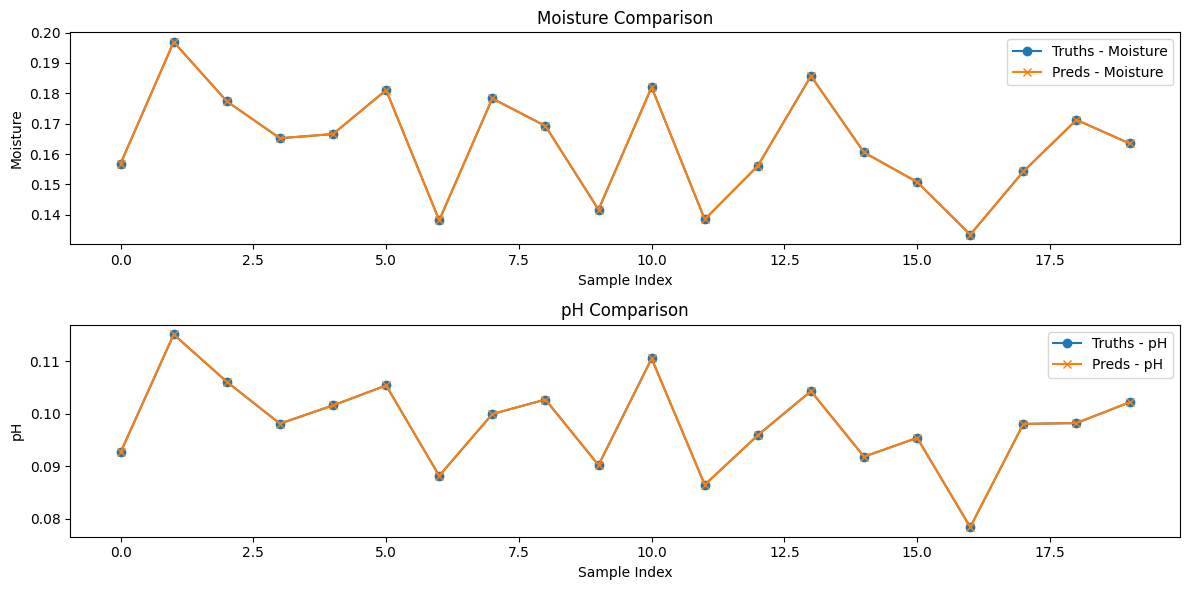

In [180]:

truths = []
preds = []
for i in range(20):
    predictions = modelB.predict(np.array([SAMPLE[i]]))
    truths.append(unprocess_label_wmask(SAMPLE[i],SAMPLE_Y[i]))
    preds.append(unprocess_label_wmask(SAMPLE[i],predictions))
truths_moisture = [truth[0] for truth in truths]
truths_ph = [truth[1] for truth in truths]
preds_moisture = [pred[0] for pred in preds]
preds_ph = [pred[1] for pred in preds]


for i in range(len(truths_moisture)):
    print("Moisture Truth : {:.2f} Pred: {:.2f}".format(truths_moisture[i], preds_moisture[i]))
    print("ph   Truth: {:.2f} Pred: {:.2f}".format(truths_ph[i], preds_ph[i]), end="\n\n")
plt.figure(figsize=(12, 6))

# Moisture Plot
plt.subplot(2, 1, 1)
plt.plot(truths_moisture, label='Truths - Moisture', marker='o')
plt.plot(preds_moisture, label='Preds - Moisture', marker='x')
plt.title('Moisture Comparison')
plt.xlabel('Sample Index')
plt.ylabel('Moisture')
plt.legend()

# pH Plot
plt.subplot(2, 1, 2)
plt.plot(truths_ph, label='Truths - pH', marker='o')
plt.plot(preds_ph, label='Preds - pH', marker='x')
plt.title('pH Comparison')
plt.xlabel('Sample Index')
plt.ylabel('pH')
plt.legend()

plt.tight_layout()
plt.show()




In [181]:
def accuracy(truth, pred):
    return (1 - abs(truth - pred) / truth) * 100

TEMP_0 = []
TEMP_1 = []
for i in range(len(truths_moisture)):
    TEMP_0.append(accuracy(truths_moisture[i],preds_moisture[i]))
    TEMP_1.append(accuracy(truths_ph[i],preds_ph[i]))
print(np.mean(np.array(TEMP_0)))
print(np.mean(np.array(TEMP_1)))

100.0
100.0


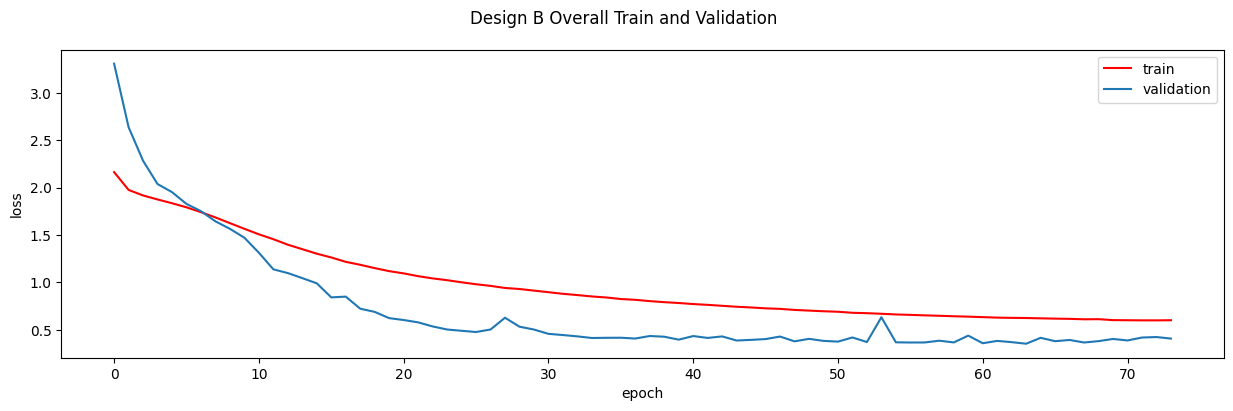

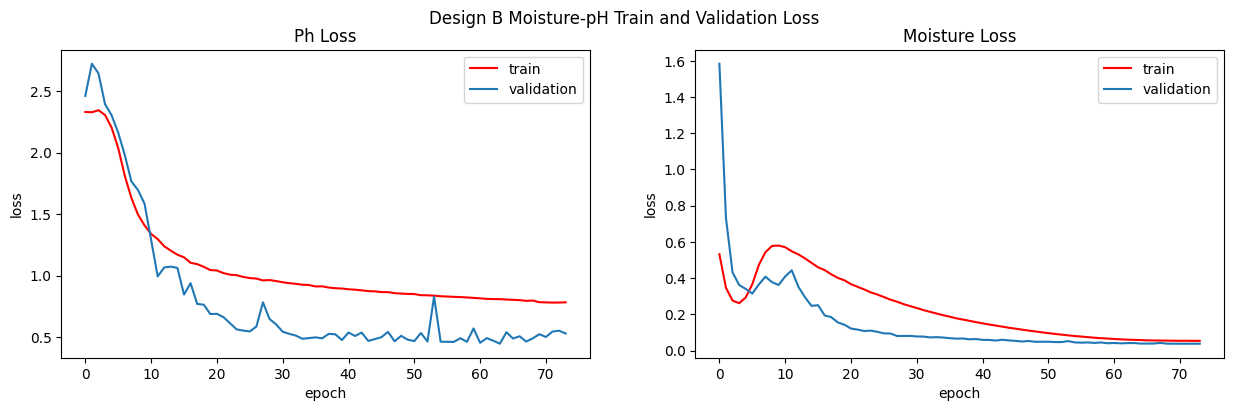

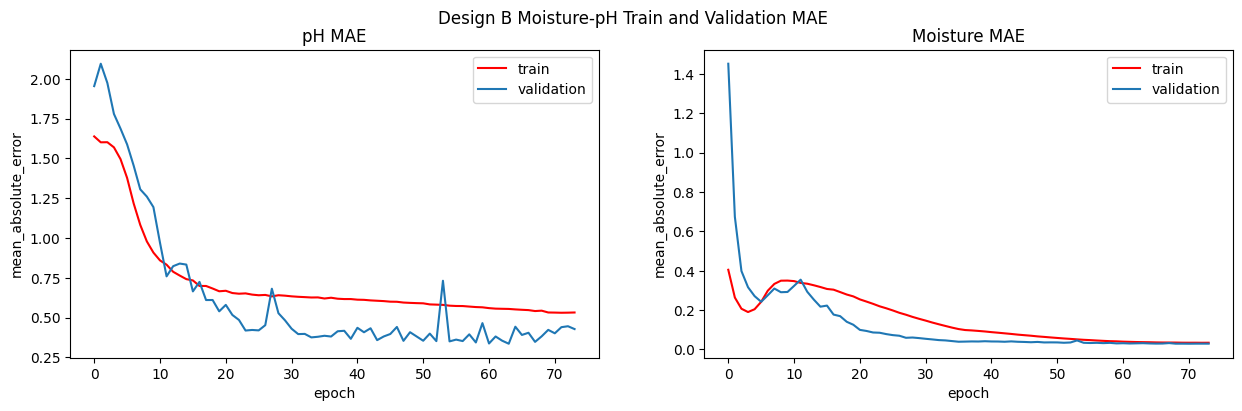

In [149]:
## Graphing Result of training
HISTORY = historyB


plt.figure(figsize=(15,4))
plt.suptitle("Design B Overall Train and Validation")

plt.subplot(111)
plt.plot(HISTORY.history['loss'], color ='r')
plt.plot(HISTORY.history['val_loss'])
plt.legend(['train','validation'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()


plt.figure(figsize=(15,4))
plt.suptitle("Design B Moisture-pH Train and Validation Loss")

plt.subplot(121)
plt.plot(HISTORY.history['ph_output_loss'], color ='r')
plt.plot(HISTORY.history['val_ph_output_loss'])
plt.title('Ph Loss')
plt.legend(['train','validation'])
plt.xlabel('epoch')
plt.ylabel('loss')

plt.subplot(122)
plt.plot(HISTORY.history['moisture_output_loss'], color ='r')
plt.plot(HISTORY.history['val_moisture_output_loss'])
plt.title('Moisture Loss')
plt.legend(['train','validation'])
plt.xlabel('epoch')
plt.ylabel('loss')

# displaying the figure
plt.show()

plt.figure(figsize=(15,4))
plt.suptitle("Design B Moisture-pH Train and Validation MAE")

plt.subplot(121)
plt.plot(HISTORY.history['ph_output_mean_absolute_error'], color ='r')
plt.plot(HISTORY.history['val_ph_output_mean_absolute_error'])
plt.title('pH MAE')
plt.legend(['train','validation'])
plt.xlabel('epoch')
plt.ylabel('mean_absolute_error')

plt.subplot(122)
plt.plot(HISTORY.history['moisture_output_mean_absolute_error'], color ='r')
plt.plot(HISTORY.history['val_moisture_output_mean_absolute_error'])
plt.title('Moisture MAE')
plt.legend(['train','validation'])
plt.xlabel('epoch')
plt.ylabel('mean_absolute_error')

# displaying the figure
plt.show()

In [150]:
## Design B
history = historyB.history

loss_keys = [key for key in history.keys() if 'loss' in key]
metric_keys = [key for key in history.keys() if 'mean_absolute_error' in key]

val_loss = history['val_loss']
best_epoch = np.argmin(val_loss)

print("Best Epoch: ", best_epoch)

for key in loss_keys + metric_keys:
    if key.startswith('val_'):
        metric_name = key[4:] 
        final_value = history[key][best_epoch]
        print(f"Final Validation {metric_name}: {final_value:.4f}")
    else:
        final_value = history[key][best_epoch]
        print(f"Final Train {key}: {final_value:.4f}")


Best Epoch:  63
Final Train loss: 0.6253
Final Train moisture_output_loss: 0.0590
Final Train ph_output_loss: 0.8089
Final Validation loss: 0.3544
Final Validation moisture_output_loss: 0.0417
Final Validation ph_output_loss: 0.4467
Final Train moisture_output_mean_absolute_error: 0.0371
Final Train ph_output_mean_absolute_error: 0.5545
Final Validation moisture_output_mean_absolute_error: 0.0319
Final Validation ph_output_mean_absolute_error: 0.3358


In [139]:
# from shutil import rmtree
# # removing directory 
# rmtree('my_dir') 

In [130]:
# modelB.save('design_models/designB_v6.h5')


### Design C

In [43]:
import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.applications import ResNet50

def DeeplabV3Plus(hp, input_shape=(64, 64, 3), num_classes=2):
    inputs = tf.keras.Input(shape=input_shape)
    
    resnet50 = ResNet50(include_top=False, weights='imagenet', input_tensor=inputs)
    
    layer_names = [
        'conv1_relu', 'conv2_block3_out', 'conv3_block4_out',
        'conv4_block6_out', 'conv5_block3_out'
    ]
    layers_output = [resnet50.get_layer(name).output for name in layer_names]

    encoder = Model(inputs=resnet50.input, outputs=layers_output)

    # Feature extraction
    stage1, stage2, stage3, stage4, stage5 = encoder(inputs)
    
    # Concatenate feature maps from stage5
    stage5_concat = layers.Concatenate()(stage5) if isinstance(stage5, list) else stage5

    UNITS = hp.Choice('units',values = [256,512,1024,2048], default=256)
    DROPOUT = hp.Float('dropout',min_value=0.0, max_value=0.5, step=0.1, default=0.0)
    BATCHNORM = hp.Boolean('batchnorm',default=False)
    
    # Dense layers between encoder and decoder
    x = layers.Flatten()(stage5_concat)
    x = Dense(UNITS, activation='relu')(x)
    x = Dropout(DROPOUT)(x)
    x = Dense(UNITS, activation='relu')(x)
    x = Dropout(DROPOUT)(x)
    x = Dense(UNITS, activation='relu')(x)
    x = Dropout(DROPOUT)(x)
    x = Dense(UNITS, activation='relu')(x)
    if BATCHNORM:
        x = BatchNormalization()(x)
    
    SIZE = input_shape[0] //32
    x = layers.Dense(SIZE * SIZE * 512, activation='relu')(x)
    x = layers.Reshape((SIZE, SIZE, 512))(x)
    
    # ASPP
    def aspp_block(x, out_channels, kernel_size, dilation):
        return layers.Conv2D(out_channels, kernel_size, padding='same', dilation_rate=dilation, activation='relu')(x)

    pool = layers.GlobalAveragePooling2D()(x)
    pool = layers.Reshape((1, 1, 512))(pool)
    pool = layers.Conv2D(256, (1, 1), activation='relu')(pool)

    shape_before = tf.keras.backend.int_shape(x)
    pool = layers.UpSampling2D(size=(shape_before[1], shape_before[2]))(pool)

    b1 = aspp_block(x, 256, 1, 1)
    b2 = aspp_block(x, 256, 3, 6)
    b3 = aspp_block(x, 256, 3, 12)
    b4 = aspp_block(x, 256, 3, 18)
    
    x = layers.Concatenate()([b1, b2, b3, b4, pool])
    x = layers.Conv2D(256, (1, 1), activation='relu')(x)
    
    # Decoder
    x = layers.UpSampling2D(size=(8, 8))(x)
    x = layers.Concatenate()([x, stage2])
    x = layers.Conv2D(256, (3, 3), padding='same', activation='relu')(x)
    x = layers.Conv2D(256, (3, 3), padding='same', activation='relu')(x)

    x = layers.UpSampling2D(size=(2, 2))(x)
    x = layers.Concatenate()([x, stage1])
    x = layers.Conv2D(256, (3, 3), padding='same', activation='relu')(x)
    x = layers.Conv2D(256, (3, 3), padding='same', activation='relu')(x)

    x = layers.UpSampling2D(size=(2, 2))(x)
    
    outputs1 = Conv2D(1, (1, 1), padding="same", activation="linear", name="moisture_output")(x)
    outputs2 = Conv2D(1, (1, 1), padding="same", activation="linear", name="ph_output")(x)
    model = tf.keras.Model(inputs=inputs, outputs=[outputs1, outputs2], name='DeepLabV3Plus')

    optimizer_choice = hp.Choice('optimizer', values=['sgd', 'rmsprop', 'adam'], default='adam')
    lr = hp.Choice('learning_rate', values=[1e-3, 1e-4, 1e-5], default=1e-3)

    if optimizer_choice == 'sgd':
        optimizer = tf.keras.optimizers.SGD(learning_rate=lr)
    elif optimizer_choice == 'rmsprop':
        optimizer = tf.keras.optimizers.RMSprop(learning_rate=lr)
    else:
        optimizer = tf.keras.optimizers.Adam(learning_rate=lr)

    model.compile(optimizer=optimizer, 
                    loss={"moisture_output":root_mean_squared_error, "ph_output":root_mean_squared_error}, 
                    metrics={"moisture_output":mean_absolute_error,"ph_output":mean_absolute_error},
                    loss_weights={'moisture_output': 1.0, 'ph_output': 0.5}
                    )
    return model


In [44]:
tunerC = kt.BayesianOptimization(DeeplabV3Plus,
                     objective='val_loss',
                     directory='my_dir_v2-06-12-2024',
                     max_trials= 30,
                     project_name='design_c',
                    #  seed=42,
                     )

stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=7)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, min_lr=1e-8)

tunerC.search(train_generator, epochs=30, validation_data=val_generator, callbacks=[stop_early, reduce_lr])

# Get the optimal hyperparameters
best_hpsC=tunerC.get_best_hyperparameters(num_trials=1)[0]

print(best_hpsC.values)

Reloading Tuner from my_dir_v2-06-12-2024\design_c\tuner0.json
{'units': 256, 'dropout': 0.1, 'batchnorm': True, 'optimizer': 'adam', 'learning_rate': 0.001}


In [45]:
modelC = DeeplabV3Plus(best_hpsC)
modelC.summary()



Model: "DeepLabV3Plus"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 model (Functional)             [(None, 32, 32, 64)  23587712    ['input_4[0][0]']                
                                , (None, 16, 16, 25                                               
                                6),                                                               
                                 (None, 8, 8, 512),                                               
                                 (None, 4, 4, 1024)                                               
                                , (None, 2, 2, 2048                                   

In [46]:
## DESIGN C
import time 
start = time.time()
historyC = modelC.fit(train_generator, epochs=epochs, validation_data=val_generator, verbose=2, callbacks = [ES, REDUCE_LR])
stop = time.time()
print(f"Training time: {stop - start}s")

Epoch 1/1024
79/79 - 13s - loss: 21.4650 - moisture_output_loss: 8.9967 - ph_output_loss: 24.9366 - moisture_output_mean_absolute_error: 0.5417 - ph_output_mean_absolute_error: 1.2373 - val_loss: 2.2641 - val_moisture_output_loss: 0.0116 - val_ph_output_loss: 4.5051 - val_moisture_output_mean_absolute_error: 0.0961 - val_ph_output_mean_absolute_error: 2.0976 - lr: 0.0010 - 13s/epoch - 165ms/step
Epoch 2/1024
79/79 - 5s - loss: 0.2049 - moisture_output_loss: 0.0181 - ph_output_loss: 0.3737 - moisture_output_mean_absolute_error: 0.1050 - ph_output_mean_absolute_error: 0.3811 - val_loss: 2.2295 - val_moisture_output_loss: 0.0488 - val_ph_output_loss: 4.3615 - val_moisture_output_mean_absolute_error: 0.1970 - val_ph_output_mean_absolute_error: 2.0635 - lr: 0.0010 - 5s/epoch - 59ms/step
Epoch 3/1024
79/79 - 5s - loss: 0.1684 - moisture_output_loss: 0.0117 - ph_output_loss: 0.3134 - moisture_output_mean_absolute_error: 0.0801 - ph_output_mean_absolute_error: 0.3338 - val_loss: 2.2252 - val_m

In [72]:
i=6
(unprocess_label_wmask(SAMPLE[i],modelC.predict(np.array([SAMPLE[i]]))))

1/1 [==============================] - 0s 22ms/step


[0.19821637878075052, 4.2189409870367784]

In [75]:
for i in SAMPLE[i]:
    print(i)

[[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]
[[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0

1/1 [==============================] - 0s 23ms/step
Moisture Truth : 0.16 Pred: 0.16
ph   Truth: 0.09 Pred: 0.09

Moisture Truth : 0.20 Pred: 0.20
ph   Truth: 0.12 Pred: 0.12

Moisture Truth : 0.18 Pred: 0.18
ph   Truth: 0.11 Pred: 0.11

Moisture Truth : 0.17 Pred: 0.17
ph   Truth: 0.10 Pred: 0.10

Moisture Truth : 0.17 Pred: 0.17
ph   Truth: 0.10 Pred: 0.10

Moisture Truth : 0.18 Pred: 0.18
ph   Truth: 0.11 Pred: 0.11

Moisture Truth : 0.14 Pred: 0.14
ph   Truth: 0.09 Pred: 0.09

Moisture Truth : 0.18 Pred: 0.18
ph   Truth: 0.10 Pred: 0.10

Moisture Truth : 0.17 Pred: 0.17
ph   Truth: 0.10 Pred: 0.10

Moisture Truth : 0.14 Pred: 0.14
ph   Truth: 0.09 Pred: 0.09

Moisture Truth : 0.18 Pred: 0.18
ph   Truth: 0.11 Pred: 0.11

Moisture Truth : 0.14 Pred: 0.14
ph   Truth: 0.09 Pred: 0.09

Moisture Truth : 0.16 Pred: 0.16
ph   Truth: 0.10 Pred: 0.10

Moisture Truth : 0.19 Pred: 0.19
ph   Truth: 0.10 Pred: 0.10

Moisture Truth : 0.16 Pred: 0.16
ph   Truth: 0.09 Pred: 0.09

Moisture Truth : 0

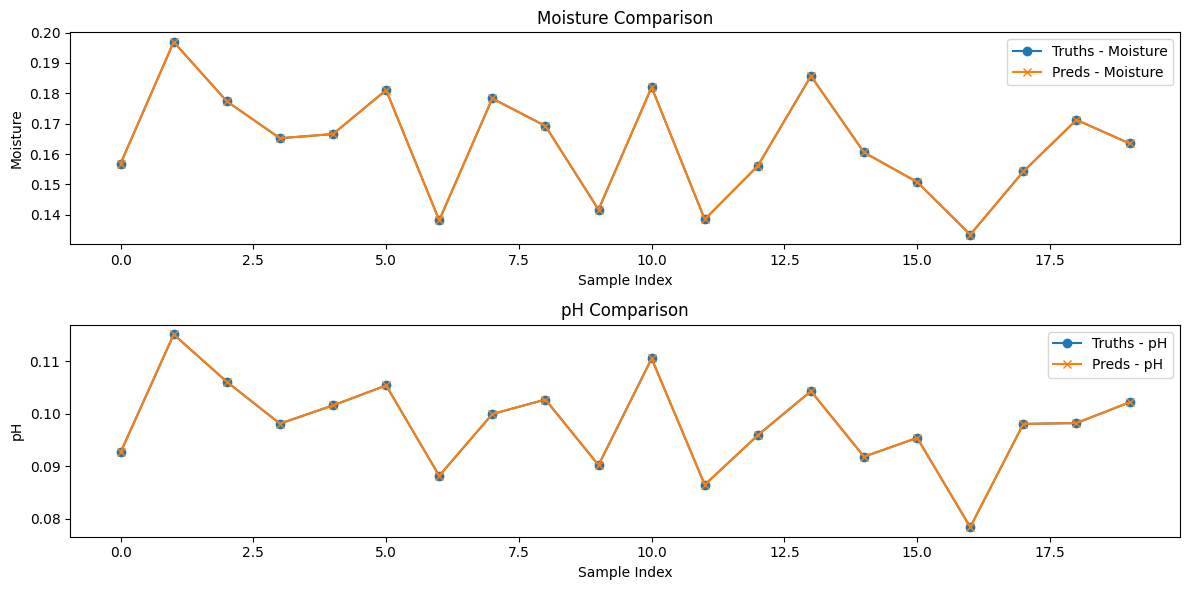

In [184]:

truths = []
preds = []
for i in range(20):
    predictions = modelC.predict(np.array([SAMPLE[i]]))
    truths.append(unprocess_label_wmask(SAMPLE[i],SAMPLE_Y[i]))
    preds.append(unprocess_label_wmask(SAMPLE[i],predictions))
truths_moisture = [truth[0] for truth in truths]
truths_ph = [truth[1] for truth in truths]
preds_moisture = [pred[0] for pred in preds]
preds_ph = [pred[1] for pred in preds]


for i in range(len(truths_moisture)):
    print("Moisture Truth : {:.2f} Pred: {:.2f}".format(truths_moisture[i], preds_moisture[i]))
    print("ph   Truth: {:.2f} Pred: {:.2f}".format(truths_ph[i], preds_ph[i]), end="\n\n")
plt.figure(figsize=(12, 6))

# Moisture Plot
plt.subplot(2, 1, 1)
plt.plot(truths_moisture, label='Truths - Moisture', marker='o')
plt.plot(preds_moisture, label='Preds - Moisture', marker='x')
plt.title('Moisture Comparison')
plt.xlabel('Sample Index')
plt.ylabel('Moisture')
plt.legend()

# pH Plot
plt.subplot(2, 1, 2)
plt.plot(truths_ph, label='Truths - pH', marker='o')
plt.plot(preds_ph, label='Preds - pH', marker='x')
plt.title('pH Comparison')
plt.xlabel('Sample Index')
plt.ylabel('pH')
plt.legend()

plt.tight_layout()
plt.show()




In [185]:
def accuracy(truth, pred):
    return (1 - abs(truth - pred) / truth) * 100

TEMP_0 = []
TEMP_1 = []
for i in range(len(truths_moisture)):
    TEMP_0.append(accuracy(truths_moisture[i],preds_moisture[i]))
    TEMP_1.append(accuracy(truths_ph[i],preds_ph[i]))
print(np.mean(np.array(TEMP_0)))
print(np.mean(np.array(TEMP_1)))

100.0
100.0


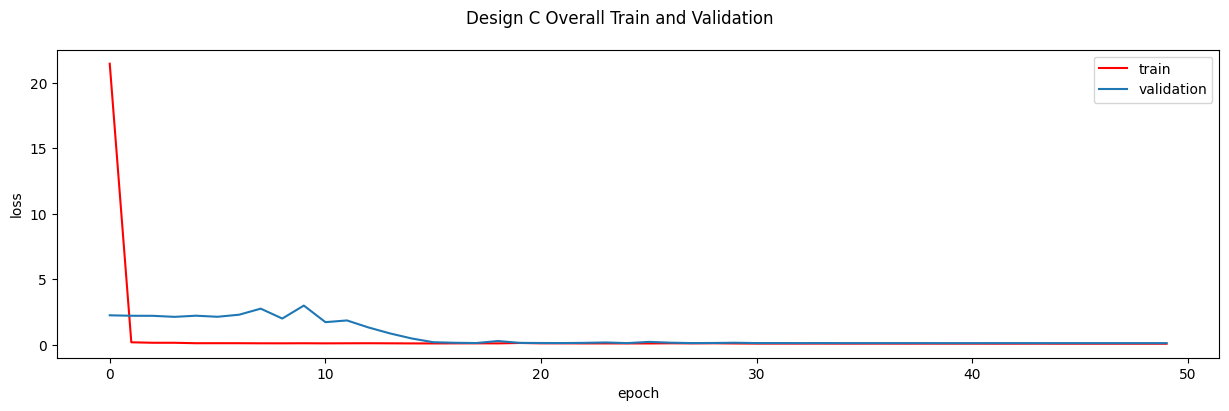

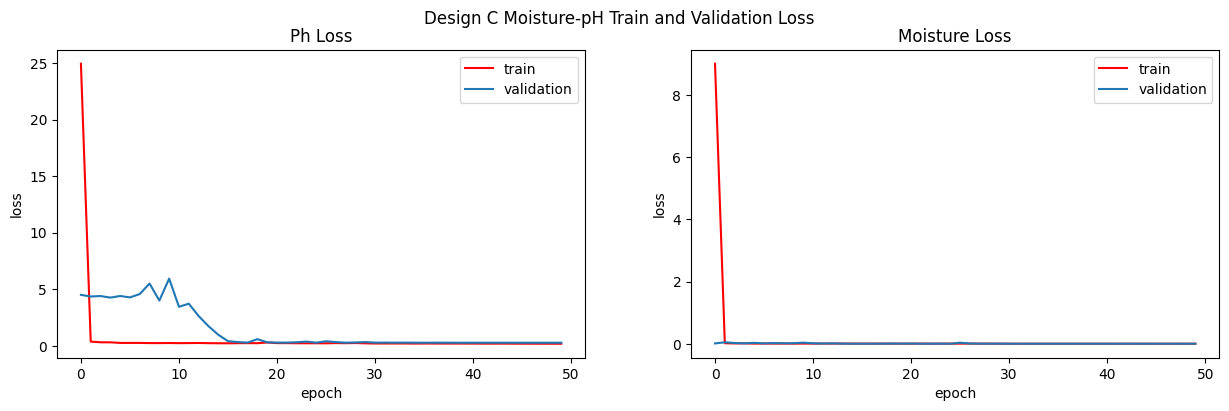

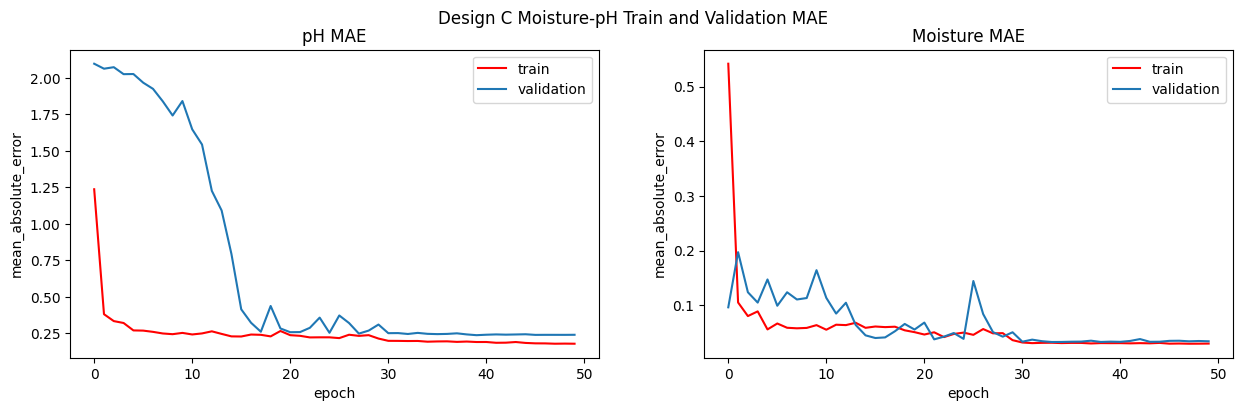

In [49]:
## Graphing Result of training
HISTORY = historyC


plt.figure(figsize=(15,4))
plt.suptitle("Design C Overall Train and Validation")

plt.subplot(111)
plt.plot(HISTORY.history['loss'], color ='r')
plt.plot(HISTORY.history['val_loss'])
plt.legend(['train','validation'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()


plt.figure(figsize=(15,4))
plt.suptitle("Design C Moisture-pH Train and Validation Loss")

plt.subplot(121)
plt.plot(HISTORY.history['ph_output_loss'], color ='r')
plt.plot(HISTORY.history['val_ph_output_loss'])
plt.title('Ph Loss')
plt.legend(['train','validation'])
plt.xlabel('epoch')
plt.ylabel('loss')

plt.subplot(122)
plt.plot(HISTORY.history['moisture_output_loss'], color ='r')
plt.plot(HISTORY.history['val_moisture_output_loss'])
plt.title('Moisture Loss')
plt.legend(['train','validation'])
plt.xlabel('epoch')
plt.ylabel('loss')

# displaying the figure
plt.show()

plt.figure(figsize=(15,4))
plt.suptitle("Design C Moisture-pH Train and Validation MAE")

plt.subplot(121)
plt.plot(HISTORY.history['ph_output_mean_absolute_error'], color ='r')
plt.plot(HISTORY.history['val_ph_output_mean_absolute_error'])
plt.title('pH MAE')
plt.legend(['train','validation'])
plt.xlabel('epoch')
plt.ylabel('mean_absolute_error')

plt.subplot(122)
plt.plot(HISTORY.history['moisture_output_mean_absolute_error'], color ='r')
plt.plot(HISTORY.history['val_moisture_output_mean_absolute_error'])
plt.title('Moisture MAE')
plt.legend(['train','validation'])
plt.xlabel('epoch')
plt.ylabel('mean_absolute_error')

# displaying the figure
plt.show()

In [50]:
## Design B
history = historyC.history

loss_keys = [key for key in history.keys() if 'loss' in key]
metric_keys = [key for key in history.keys() if 'mean_absolute_error' in key]

val_loss = history['val_loss']
best_epoch = np.argmin(val_loss)

print("Best Epoch: ", best_epoch)

for key in loss_keys + metric_keys:
    if key.startswith('val_'):
        metric_name = key[4:] 
        final_value = history[key][best_epoch]
        print(f"Final Validation {metric_name}: {final_value:.4f}")
    else:
        final_value = history[key][best_epoch]
        print(f"Final Train {key}: {final_value:.4f}")


Best Epoch:  39
Final Train loss: 0.1020
Final Train moisture_output_loss: 0.0026
Final Train ph_output_loss: 0.1989
Final Validation loss: 0.1389
Final Validation moisture_output_loss: 0.0024
Final Validation ph_output_loss: 0.2729
Final Train moisture_output_mean_absolute_error: 0.0305
Final Train ph_output_mean_absolute_error: 0.1904
Final Validation moisture_output_mean_absolute_error: 0.0333
Final Validation ph_output_mean_absolute_error: 0.2373


In [51]:
# from shutil import rmtree
# # removing directory 
# rmtree('my_dir') 

In [52]:
# modelC.save('design_models/designC_v6.h5')


## Evaluating Constraints

### MANUFACTURABILITY: TRAINING TIME

In [53]:
# # modelA = tf.keras.models.load_model('design_models/designA_v7.h5')
# modelB = tf.keras.models.load_model('design_models/designB_v7.h5')
# # modelC = tf.keras.models.load_model('design_models/designC_v7.h5')


In [54]:
# epochs = 128
# REDUCE_LR = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1,
#                               patience=5, min_lr=1e-9)
# ES = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=16, mode="min", restore_best_weights=True)

In [55]:
# ## DESIGN A
# import time 
# start = time.time()
# historyA = modelA.fit(train_generator, epochs=epochs, validation_data=val_generator, verbose=2, callbacks = [es, reduce_lr])
# stop = time.time()
# print(f"Training time: {stop - start}s")

# # ## FUNCTIONALITY: INFERENCE TIME
# # modelC.evaluate(train_generator[1][0][0].reshape(1,32,32,3))

In [56]:
# ## DESIGN B
# import time 
# start = time.time()
# historyB = modelB.fit(train_generator, epochs=epochs, validation_data=val_generator, verbose=2, callbacks = [es, reduce_lr])
# stop = time.time()
# print(f"Training time: {stop - start}s")

In [57]:
# ## DESIGN C
# import time 
# start = time.time()
# historyC = modelC.fit(train_generator, epochs=epochs, validation_data=val_generator, verbose=2, callbacks = [es, reduce_lr])
# stop = time.time()
# print(f"Training time: {stop - start}s")

### ECONOMIC: FLOATING-POINT OPERATIONS PER SECOND

In [154]:
## Design A
## ECONOMIC: FLOATING-POINT OPERATIONS PER SECOND
# Calculate FLOPS
from keras_flops import get_flops
flopsA = get_flops(modelA, batch_size=1)
print(f"FLOPS: {flopsA}")

FLOPS: 1892644106


In [155]:
## Design B
## ECONOMIC: FLOATING-POINT OPERATIONS PER SECOND
# Calculate FLOPS
from keras_flops import get_flops
flopsB = get_flops(modelB, batch_size=1)
print(f"FLOPS: {flopsB}")

FLOPS: 4288301206


In [378]:
## Design C
## ECONOMIC: FLOATING-POINT OPERATIONS PER SECOND
# Calculate FLOPS
from keras_flops import get_flops
flopsC = get_flops(modelC, batch_size=1)
print(f"FLOPS: {flopsC}")

FLOPS: 5460291464


### FUNCTIONALITY: INFERENCE TIME

In [217]:
inference_sample = train_generator[1][0][0].reshape(1,64,64,3)

In [373]:
import time
## Design A
## FUNCTIONALITY: INFERENCE TIME
start = time.time()
modelA.predict(inference_sample)
stop = time.time()
print(f"Inference time: {(stop - start)*1e3:.4f}ms")


1/1 [==============================] - 0s 24ms/step
Inference time: 143.5163ms


In [355]:
## Design B
## FUNCTIONALITY: INFERENCE TIME
start = time.time()
modelB.predict(inference_sample)
stop = time.time()
print(f"Inference time: {(stop - start)*1e3:.4f}ms")


1/1 [==============================] - 0s 22ms/step
Inference time: 137.4168ms


In [377]:
## Design AC
## FUNCTIONALITY: INFERENCE TIME
start = time.time()
modelC.predict(inference_sample)
stop = time.time()
print(f"Inference time: {(stop - start)*1e3:.4f}ms")


1/1 [==============================] - 0s 25ms/step
Inference time: 181.9561ms


### PERFORMANCE: COEFFICIENT OF DETERMINATION

In [305]:
import numpy as np
from sklearn.metrics import r2_score

y_values_1 = np.array(y_values_1)
predictionsA = modelA.predict(gen_X_values_1_1)

y_values_flat_0 = y_values_1[: ,0].flatten()
predictionsA_flat_0 = predictionsA[0].flatten()

y_values_flat_1 = y_values_1[: ,1].flatten()
predictionsA_flat_1 = predictionsA[1].flatten()

# Calculate R^2 score for each class
r2_score_0 = r2_score(y_values_flat_0, predictionsA_flat_0)
r2_score_1 = r2_score(y_values_flat_1, predictionsA_flat_1)

print(f'R^2 for class 0: {r2_score_0:.4f}')
print(f'R^2 for class 1: {r2_score_1:.4f}')

print(f"Average R^2 score: {(r2_score_0+r2_score_1)/2:.4f}")



79/79 [==============================] - 2s 23ms/step
R^2 for class 0: 0.7858
R^2 for class 1: 0.9622
Average R^2 score: 0.8740


In [306]:
## Design B
## PERFORMANCE: COEFFICIENT OF DETERMINATION

y_values_1 = np.array(y_values_1)
predictionsA = modelB.predict(gen_X_values_2_1)

y_values_flat_0 = y_values_1[: ,0].flatten()
predictionsA_flat_0 = predictionsA[0].flatten()

y_values_flat_1 = y_values_1[: ,1].flatten()
predictionsA_flat_1 = predictionsA[1].flatten()

# Calculate R^2 score for each class
r2_score_0 = r2_score(y_values_flat_0, predictionsA_flat_0)
r2_score_1 = r2_score(y_values_flat_1, predictionsA_flat_1)

print(f'R^2 for class 0: {r2_score_0:.4f}')
print(f'R^2 for class 1: {r2_score_1:.4f}')

print(f"Average R^2 score: {(r2_score_0+r2_score_1)/2:.4f}")



      1/Unknown - 0s 24ms/step

79/79 [==============================] - 1s 15ms/step
R^2 for class 0: 0.8306
R^2 for class 1: 0.9635
Average R^2 score: 0.8971


In [307]:
## Design C
## PERFORMANCE: COEFFICIENT OF DETERMINATION
y_values_1 = np.array(y_values_1)
predictionsA = modelC.predict(gen_X_values_3_1)

y_values_flat_0 = y_values_1[: ,0].flatten()
predictionsA_flat_0 = predictionsA[0].flatten()

y_values_flat_1 = y_values_1[: ,1].flatten()
predictionsA_flat_1 = predictionsA[1].flatten()

# Calculate R^2 score for each class
r2_score_0 = r2_score(y_values_flat_0, predictionsA_flat_0)
r2_score_1 = r2_score(y_values_flat_1, predictionsA_flat_1)

print(f'R^2 for class 0: {r2_score_0:.4f}')
print(f'R^2 for class 1: {r2_score_1:.4f}')

print(f"Average R^2 score: {(r2_score_0+r2_score_1)/2:.4f}")




79/79 [==============================] - 1s 18ms/step
R^2 for class 0: 0.8211
R^2 for class 1: 0.9609
Average R^2 score: 0.8910


### EFFICIENCY: STORAGE CONSUMPTION

In [ ]:
## EFFICIENCY: STORAGE CONSUMPTION
weightsA = modelA.get_weights()
total_sizeA = 0
for weight in weightsA:
    total_sizeA += tf.size(weight).numpy()

print(f"Total model weight size in megabytes: {total_sizeA*8e-6:.4f}")

Total model weight size in megabytes: 672.0036


In [ ]:
## EFFICIENCY: STORAGE CONSUMPTION
weightsB = modelB.get_weights()
total_sizeB = 0
for weight in weightsB:
    total_sizeB += tf.size(weight).numpy()

print(f"Total model weight size in megabytes: {total_sizeB*8e-6:.4f}")

Total model weight size in megabytes: 326.1677


In [175]:
## EFFICIENCY: STORAGE CONSUMPTION
weightsC = modelC.get_weights()
total_sizeC = 0
for weight in weightsC:
    total_sizeC += tf.size(weight).numpy()

print(f"Total model weight size in megabytes: {total_sizeC*8e-6:.4f}")

Total model weight size in megabytes: 269.1062


In [ ]:
# modelB.save('design_models/designB_v10.h5')


## Saving final trained and constrained models

In [188]:
modelA.save('design_models/designA_v12.h5')
modelB.save('design_models/designB_v12.h5')
modelC.save('design_models/designC_v12.h5')

# Testing Accuracy of Models

In [ ]:
## Prepare set of x values and y values for performance constraint
X_values,y_values = [],[]
for i in range(100):
    values = next(val_generator)
    # for j in range(values[0].shape[0]):
    X_values.append(values[0])
    y_values.append(values[1])